# UMAP and HDBSCAN Integration
In this notebook we show how to integrate annchor with the UMAP dimensionality reduction algorithm, and the HDBSCAN clustering algorithm. We will use annchor's string data set as an example

## Import modules and load string data set

In [1]:
import numpy as np
import time
import Levenshtein as lev
import os
from annchor.datasets import load_strings
from matplotlib import pyplot as plt
from hdbscan import HDBSCAN
from umap import UMAP



k=15  # Use n_neighbours=15

def levdist(a,b):
    return lev.distance(a,b)

strings_data = load_strings()
X = strings_data['X']
y = strings_data['y']
neighbor_graph = strings_data['neighbor_graph']

nx = X.shape[0]

for x in X[::100]:
    print(x[:50]+'...')

cuiojvfnseoksugfcbwzrcoxtjxrvojrguqttjpeauenefmkmv...
uiofnsosungdgrxiiprvojrgujfdttjioqunknefamhlkyihvx...
cxumzfltweskptzwnlgojkdxidrebonxcmxvbgxayoachwfcsy...
cmjpuuozflodwqvkascdyeosakdupdoeovnbgxpajotahpwaqc...
vzdiefjmblnumdjeetvbvhwgyasygrzhuckvpclnmtviobpzvy...
nziejmbmknuxdhjbgeyvwgasygrhcpdxcgnmtviubjvyzjemll...
yhdpczcjxirmebhfdueskkjjtbclvncxjrstxhqvtoyamaiyyb...
yfhwczcxakdtenvbfctugnkkkjbcvxcxjwfrgcstahaxyiooeb...
yoftbrcmmpngdfzrbyltahrfbtyowpdjrnqlnxncutdovbgabo...
tyoqbywjhdwzoufzrqyltahrefbdzyunpdypdynrmchutdvsbl...
dopgwqjiehqqhmprvhqmnlbpuwszjkjjbshqofaqeoejtcegjt...
rahobdixljmjfysmegdwyzyezulajkzloaxqnipgxhhbyoztzn...
dfgxsltkbpxvgqptghjnkaoofbwqqdnqlbbzjsqubtfwovkbsk...
pjwamicvegedmfetridbijgafupsgieffcwnmgmptjwnmwegvn...
ovitcihpokhyldkuvgahnqnmixsakzbmsipqympnxtucivgqyi...
xvepnposhktvmutozuhkbqarqsbxjrhxuumofmtyaaeesbeuhf...


## Run Annchor
We find the k-NN graph with annchor by calling the .fit method. Since we know the exact k-NN graph, we can also examine our accuracy. (Remember, run time is effected by the numba.jit compilation time on the first run).

In [2]:
from annchor import Annchor
from annchor import compare_neighbor_graphs


start_time = time.time()
ann = Annchor(X,
              levdist,
              n_anchors=23,
              n_neighbors=k,
              random_seed=5,
              n_samples=5000,
              p_work=0.12)

ann.fit()
print('ANNchor Time: %5.3f seconds' % (time.time()-start_time))


# Test accuracy
error = compare_neighbor_graphs(neighbor_graph,
                                ann.neighbor_graph,
                                k)
print('ANNchor Accuracy: %d incorrect NN pairs (%5.3f%%)' % (error,100*error/(k*nx)))

ANNchor Time: 58.370 seconds
ANNchor Accuracy: 2 incorrect NN pairs (0.008%)


## Extract distance matrix
Annchor allows us to extract the k-NN graph as a sparse all-pairs distance matrix. To do this, we use the .to_sparse_matrix() method.

In [3]:
# Extract the distance matrix
D = ann.to_sparse_matrix()

## UMAP integration
Now that we have the sparse distance matrix, it is trivial to integrate with UMAP. There are a few gotchas to watch out for: First we must set the metric to 'precomputed'; second we must specify n_neighbors to be k-1 (annchor counts a point as its own nearest neighbor, UMAP does not).

/Users/x2021595/Library/Python/3.8/lib/python/site-packages/umap/umap_.py:1768: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


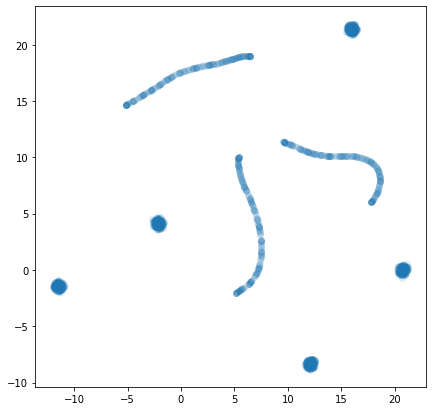

In [4]:
# Use UMAP to visualise the data
# Since we already have our distance matrix, this bit is quite easy!

U = UMAP(metric='precomputed',n_neighbors=k-1)
T = U.fit_transform(D)
# T now holds the 2d UMAP projection of our data

# View the 2D projection with matplotlib
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(*T.T,alpha=0.1)
plt.show()

## HDBSCAN integration
To use Annchor with HDBSCAN, we'll convert the sparse matrix to dense. Once that step is complete, using HDBSCAN on our data to find clusters is straightforward.

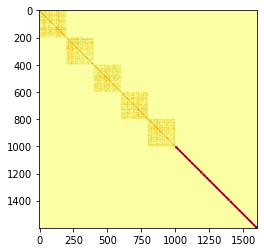

In [5]:
# Convert sparse distance matrix to dense distance matrix
dense = D.todense().astype(float)

# Set uncomputed distances to be twice the maximum distance
maxd = np.max(dense)
dense[dense==0]=2*maxd

# In the last step we made items far away from themselves, so we should undo this.
dense -= np.identity(len(X))*2*maxd

# Take a look at the distance matrix (we should immediately spot some structure!)
fig,ax = plt.subplots(figsize=(4,4))
ax.imshow(dense,cmap=plt.cm.inferno)
plt.show()

In [6]:
# Run hdbscan clustering
clusterer = HDBSCAN(metric='precomputed')
labels = clusterer.fit_predict(dense)
n_labels = len(set(labels).difference({-1}))
n_noise = np.sum(labels==-1)

#How many clusters do we find?
print('number of clusters = %d' % n_labels)

# How many points are 'noise'?
print('number of noise points = %d' % np.sum(labels==-1))

number of clusters = 8
number of noise points = 0


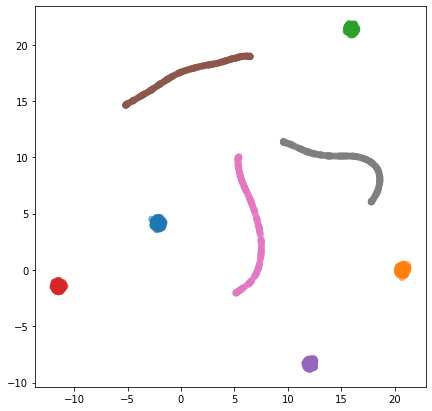

In [7]:
# Visualise the clusters using matplotlib

fig,ax = plt.subplots(figsize=(7,7))

# Plot noise (if present)
ax.scatter(*T[labels==-11].T,
           c='k',
           marker='.',
           alpha=0.1)

# Plot clusters
ax.scatter(*T[labels>-1].T,
           c=labels[labels>-1],
           cmap=plt.cm.tab10,
           vmin=0,
           vmax=10,
           marker='o',
           alpha=0.5)
plt.show()